### Recap

Previously, we took an early look at the data and started evaluating models using only five features. Our naive baseline is set at 0.6616 which is was matched fairly well by naive implementations of the other models. It is time to further investigate the data to narrow down to a candidate model.

| Metrics | K Nearest Neighbor | Logistic Regression | Gaussian Naive Bayes | Support Vector Machine | Decision Tree | Random Forest | 
| ----: | :----: | :----: | :----: | :----: | :----: | :----: |
| **Accuracy** | 0.595220 | 0.661384 | 0.661384 | 0.661384 | 0.610965 | 0.619717 |
| **Precision** | 0.694881 | 0.661384 | 0.661384 | 0.661384 | 0.704984 | 0.698451 |
| **Recall** | 0.819655 | 1.000000 | 1.000000 | 1.000000 | 0.923297 | 0.937549 | 
| **F1** | 0.752129 | 0.796184 | 0.796184 | 0.796184 | 0.799505 | 0.800528 | 

Since the last notebook, I have written a Python function that will convert the many text values to the numbers needed for analysis. The below data ingestion and conversion is the same as the first notebook.

### Review current features

### Getting data into the notebook

As a reminder, the analysis in the first notebook only contained the following features:

Namely...
- Hobbyist: Do you code as a hobby?
- OpenSourcer: How often do you contribute to open source?
- LastHireDate: When was the last time that you took a job with a new employer?
- SOVisitFreq: How frequently would you say you visit Stack Overflow?
- YearsCode: Including any education, how many years have you been coding?

Since then I have added the following features (programatically) in advance of further investigation:

```
Age, Age1stCode, BetterLife, CodeRevHrs, ConvertedComp, Dependents, FizzBuzz, ImpSyn, 
LastHireDate, MgrIdiot, MgrMoney, MgrWant, OpenSource,OrgSize, PurchaseWhat, SOPartFreq,
Student, SurveyEase, SurveyLength, WorkRemote, WorkWeekHrs, YearsCodePro,
Africa, Americas, Asia, Europe, India, MiddleEast, Oceania, OtherCountry, United States
```

We also previously dropped the following columns: `MainBranch` and `Employment` since we filtered down to only one acceptable value for those features and the following branches in favor of the singular column `ConvertedComp`: `CurrencySymbol`, `CurrencyDesc`, `CompTotal` , `CompFreq`.

In addition, for this iteration, the following columns were dropped as they were too close to the target variable: `CareerSat` and `JobSeek`.

The below section gets us the data from the first notebook with the updates described above.

In [1]:
import pandas as pd
import stackoverflow_helper as soh
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
raw_import = pd.read_csv('/Users/pang/repos/stack-overflow-survey/_data/developer_survey_2019/survey_results_public.csv', \
                         index_col='Respondent')

In [3]:
df_big = soh.get_analysis_data(raw_import, ['Age', 'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'Country'])

In [4]:
y_big = df_big['JobSat']
X_big = df_big.drop(columns='JobSat')
X_train_big, X_test_final, y_train_big, y_test_final = train_test_split(X_big, y_big, test_size=0.20, random_state=4444)

## Finding a model.

Previously we just ran the numbers against itself. I will look at how the naive models behave on test data.

In [5]:
y = y_train_big
X = X_train_big
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4444)
df = pd.DataFrame(y_train).merge(X_train, on='Respondent')

In [6]:
# Evaluating models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

lr = LogisticRegression(solver= 'liblinear')
lr.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

svc = SVC(gamma='scale')
svc.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [8]:
classifier_scores = {}

for name, classifier in [('K Nearest Neighbor', knn), 
                         ('Logistic Regression',lr), 
                         ('Gaussian Naive Bayes',gnb), 
                         ('Support Vector Machine',svc), 
                         ('Decision Tree',dtc), 
                         ('Random Forest',rfc)]:
    accuracy = cross_val_score(classifier, X_test, y_test, cv=5, scoring='accuracy')
    precision = precision_score(y_test,classifier.predict(X_test))
    recall = recall_score(y_test,classifier.predict(X_test))
    f1 = f1_score(y_test,classifier.predict(X_test))
    
    classifier_scores[name] = {
        'Accuracy' : accuracy.mean(),
        'Precision' : precision,
        'Recall' : recall,
        'F1' : f1
    }

scores = pd.DataFrame(classifier_scores)
scores

,K Nearest Neighbor,Logistic Regression,Gaussian Naive Bayes,Support Vector Machine,Decision Tree,Random Forest
Accuracy,0.591140,0.660813,0.659794,0.660813,0.625805,0.670328
Precision,0.673712,0.660813,0.661792,0.660813,0.711064,0.734383
Recall,0.786902,1.000000,0.985256,1.000000,0.697411,0.775930
F1,0.725921,0.795771,0.791761,0.795771,0.704172,0.754585


In [9]:
roc_curve_data = []

for name, classifier in [('K Nearest Neighbor', knn), 
                         ('Logistic Regression',lr),
                         ('Gaussian Naive Bayes',gnb),
                         ('Decision Tree',dtc), 
                         ('Random Forest',rfc)]:
    
    fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    roc_curve_data.append([name, fpr, tpr])

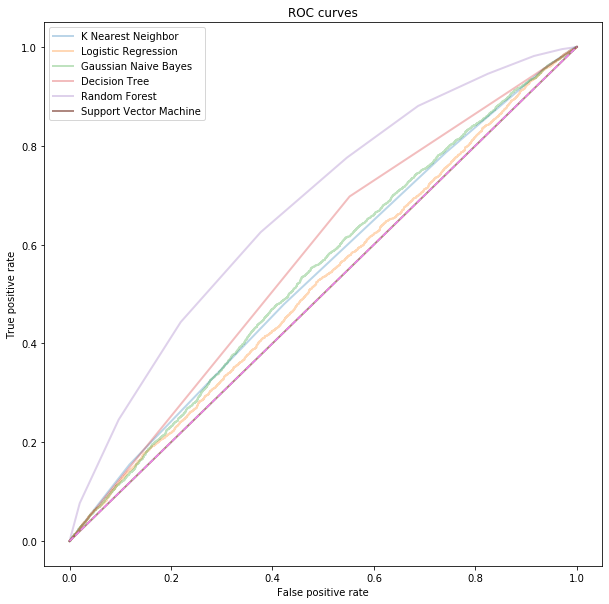

In [10]:
plt.figure(figsize=(10,10))

for name, fpr, tpr in roc_curve_data:
    plt.plot(fpr, tpr,lw=2, label=name, alpha=.3)

# Support Vector Machine has no predict_proba function so needs its own section
roc_fpr, roc_tpr, _ = roc_curve(y_test, svc.predict(X_test))
plt.plot(roc_fpr, roc_tpr,lw=2, label='Support Vector Machine', alpha=.7)

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend();

In [11]:
for name, classifier in [('K Nearest Neighbor', knn), 
                         ('Logistic Regression',lr), 
                         ('Gaussian Naive Bayes',gnb), 
                         ('Decision Tree',dtc), 
                         ('Random Forest',rfc)]:
    print(f'ROC AUC score of {name} is:', roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))
print(f'ROC AUC score of Support Vector Machine is:', roc_auc_score(y_test, svc.predict(X_test)))

ROC AUC score of K Nearest Neighbor is: 0.539597309940757
ROC AUC score of Logistic Regression is: 0.5199335181019791
ROC AUC score of Gaussian Naive Bayes is: 0.5426110807820568
ROC AUC score of Decision Tree is: 0.5726535361138873
ROC AUC score of Random Forest is: 0.6717408472582631
ROC AUC score of Support Vector Machine is: 0.5


Based on the performance of Random Forest, I will focus on this model to tune while continuing to add more features. It's interesting to note that I greatly increased the number of features and none of the metrics seem to take in the new information in any meaningful way.

More feature manipulation is in the future.